In [423]:
import pandas as pd
import numpy as np 

from collections import Counter

In [424]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [425]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
#!pip freeze > requirements.txt
#!pip install -r requirements.txt

In [426]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [427]:
#df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания 
#sample_submission = pd.read_csv('submission.csv') # самбмишн                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test,df_train], axis=0).reset_index(drop=True) # объединяем
data.tail(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2
515737,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208,1,8.8


In [428]:
sample_submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [429]:
# Предварительный анализ
data['hotel_name'].nunique()
data['review_date'] = pd.to_datetime(data['review_date'])

In [430]:
##  Загружаем данные
#hotels = pd.read_csv('hotels.csv')
##hotels0 = hotels.copy()
#hotels.info()

hotels = data.copy()

#  1.  Отчистка

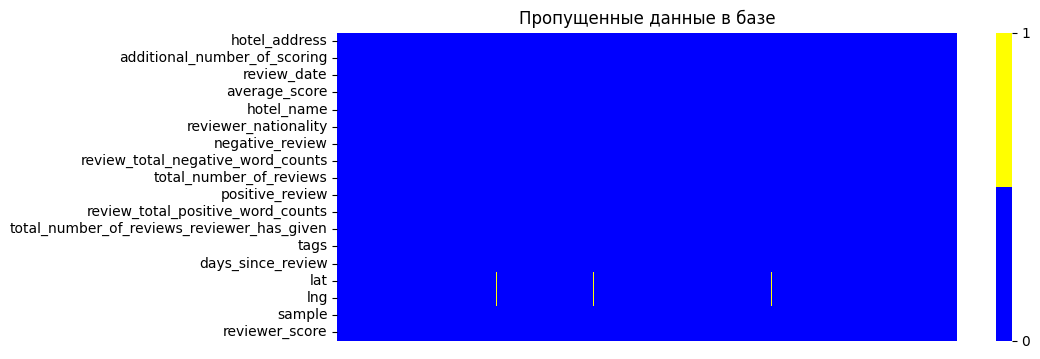

In [431]:
# Загружаем необходимые для визуализации библиотеки
import matplotlib.pyplot as plt
import seaborn as sns

# Строим тепловую карту, где желтым отмечены пропущеные значения
cbar_kws = { 'ticks' : [0,1] }
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    hotels.T.isnull(), # Создаем карту пропущенных значений в базе данных
    cmap=sns.color_palette(colors),
    xticklabels=False,
    cbar_kws = cbar_kws
)
ax.set_title('Пропущенные данные в базе');

In [432]:
# Проверим на наличие дубликатов и отфильтруем их 

L0=len(hotels)
L1=len(hotels.drop_duplicates())
print('Обнаружено {} дубликатов'.format(L0-L1))
#hotels.drop_duplicates(inplace=True)

Обнаружено 336 дубликатов


In [433]:
hotels0 = hotels.copy()

In [434]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

# Заполняем пропуски географических координат. (Генерация признаков)

In [435]:
# Сначала подключим необходимые библиотеку и модуль для поиска географических координат 
# #!pip install geopy

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="AzureMaps")
location = geolocator.geocode("Hotel Wien City")

#  Проверка
print(location.address)
print((location.latitude, location.longitude))

Wien Rathaus, 1, Rathausplatz, Schottenviertel, Innere Stadt, Wien, 1010, Österreich
(48.2108257, 16.356572796366468)


In [436]:
## Создадим словарь для пропущеных значений географических координат 
# Ключи словаря - уникальные адреса, для которых пропущены lat и lng
keys = hotels[hotels['lng'].isnull()]['hotel_address'].unique()


# Проблема: сооответствующте адреса содержат опечатки, например пропуски специальных символов. Поэтому будем восстанавливать только по индексу, городу и стране.
# Создадим функции для их нахождения
def f_lat(xx):
    shortaddress = xx.split(' ')[-3:len(xx)]
    location = geolocator.geocode(shortaddress)
    lat = location.latitude
    return  lat

def f_lng(xx):
    shortaddress = xx.split(' ')[-3:len(xx)]
    location = geolocator.geocode(shortaddress)
    lng = location.longitude
    return  lng


# Заполняем словари
lat_dict = {}
lng_dict = {}

for key in keys:
        lng_dict[key] = f_lng(key)
        lat_dict[key] = f_lat(key)
        


In [437]:
# Заполняем пропуски 
hotels['lat'] = hotels['lat'].fillna(hotels['hotel_address'].map(lat_dict))
hotels['lng'] = hotels['lng'].fillna(hotels['hotel_address'].map(lng_dict))

# Удаляем столбец адресов за ненадобностью, так как в нем опечатки, и географические координаты вполне его заменяют
hotels.drop(['hotel_name','hotel_address'], axis=1, inplace=True) 
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   reviewer_nationality                        515738 non-null  object        
 4   negative_review                             515738 non-null  object        
 5   review_total_negative_word_counts           515738 non-null  int64         
 6   total_number_of_reviews                     515738 non-null  int64         
 7   positive_review                             515738 non-null  object        
 8   review_total_positive_word_counts           515738 non-null  int64        

# Национальность

In [438]:
#!pip install geopy pycountry==22.3.5

In [439]:
from geopy.geocoders import Nominatim
#import pycountry

# Создаем функцию нахождения координат страны
# Так как геолокатор отдает предпочтение штатам, а не странам, приходится повторять название страны дважды, 
# а из списка найденных ответов выбирать тот, что имеет самый короткий адрес.

def get_coordinates(country):
    try:
        #country_obj = pycountry.countries.get(name=country)
        if country == ' ': return None, None
        else: 
            geolocator = Nominatim(user_agent="Google")
            correctionstupidamericans = country + ',' + country 
            location = geolocator.geocode(correctionstupidamericans, exactly_one=False)
            
            if location is None:
                newlocation = geolocator.geocode(country)
                #ans = next(filter(lambda xxx: len(xxx.address.split(',')) == min( len(x.address.split(',')) for x in location ) , location), 'gggg' )
                return newlocation.latitude, newlocation.longitude
                #if newlocation is None:
                #    return None, None
                #else:
                #    return newlocation.latitude, newlocation.longitude
                #realanswerstupidamericans = next(filter(lambda xxx: len(xxx.address.split(',')) == min( len(x.address.split(',')) for x in location ) , location), None)
                #return realanswerstupidamericans.latitude, realanswerstupidamericans.longitude
                    
            elif len(location) == 1:
                return location[0].latitude, location[0].longitude
            else:
                #location0 = geolocator.geocode(country)
                realanswerstupidamericans = next(filter(lambda xxx: len(xxx.address.split(',')) == min( len(x.address.split(',')) for x in location ) , location), 'ffffff' )
                return realanswerstupidamericans.latitude, realanswerstupidamericans.longitude
        
    except: #AttributeError:
        return None, None

In [440]:
 get_coordinates('Russia, Russia')

(41.0439808, -74.5358573)

In [441]:
reviewer_nationality_list = hotels['reviewer_nationality'].unique()
print(len(reviewer_nationality_list))

# Using Dictionary comprehension
reviewer_nationality_dict = {key: get_coordinates(key) for key in reviewer_nationality_list}
#print(reviewer_nationality_dict)

227


In [442]:
hotels['lat_nationality'] , hotels['lng_nationality'] =  zip( *hotels['reviewer_nationality'].map( reviewer_nationality_dict ) );

In [443]:
#  CСписок потерянных национальностей
xx = hotels[['reviewer_nationality','lat_nationality','lng_nationality']]
null_mask = xx.isnull().any(axis=1)
null_rows = xx[null_mask]

Counter(null_rows['reviewer_nationality'])

Counter({' Australia ': 21686,
         ' Iran ': 1086,
         ' ': 523,
         ' Georgia ': 294,
         ' Panama ': 122,
         ' Peru ': 118})

In [444]:
hotels.drop(['reviewer_nationality'],axis=1,inplace=True)

In [445]:
#counry = 'Abkhazia Georgia'
#location1 = geolocator.geocode(counry,exactly_one=False)
#location2 = geolocator.geocode(counry + ','+ counry,exactly_one=False)
#location = location1+location2
#xx = next(filter(lambda xxx: len(xxx.address.split(',')) == min( len(x.address.split(',')) for x in location ) , location), None)
#print(xx.latitude,xx.longitude)

In [446]:
#get_coordinates('Abkhazia Georgia')

In [447]:
#enc = ce.OrdinalEncoder();
#hotels['reviewer_nationality'] = enc.fit_transform(hotels['reviewer_nationality'])
#xx =  Counter(hotels['reviewer_nationality']) 
#xx

# Приведем дату в формат datetime

In [448]:
hotels['review_date']=pd.to_datetime(hotels['review_date'],dayfirst=True)
hotels['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [449]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split(' ')[0]) )

In [450]:
hotels.drop(['review_date'], axis=1, inplace=True)

# Приведем в порядок тэги

In [451]:
# Создадим список уникальных тегов

input_list = list(hotels['tags'].unique())

alltags=']'
for i in input_list:
    alltags += i
alltags = alltags + '['

alltags = alltags.replace('][',', ').replace("'",'')
alltags = list(alltags.split(", "))

#setoftags = set(alltags)
#print( len(setoftags) )
#setoftags = list(setoftags)

In [452]:
# Создадим для уникальных тегов словарь с количеством их использования в предоставленных данных
 
tagdict = Counter(alltags)

print('The most popular tag is ', max( tagdict.items(), key = lambda x: x[1] )[0] )

The most popular tag is   Leisure trip 


In [453]:
tagdict0 = tagdict.copy()

###  Количество ночей

In [454]:
# Создадим новый столбец с количеством проведенных ночей, проведенных ревьюером в отеле
# вычленим соответствующие значения из тегов типа 'Stayed (.*?) night'

regex = 'Stayed (.*?) night' 
hotels['nights'] = hotels['tags'].str.findall(regex).str.get(0)
hotels['nights'].fillna(value=0, inplace=True)
hotels['nights'] = hotels['nights'].apply(int)
max(hotels['nights'])

31

In [455]:
# Удалим из созданного ранее словаря тегов данные для 'Stayed (.*?) night'

#for i in range(2,30):
#    key = ' Stayed '+str(i)+' nights '
#    tagdict.pop( key)

#tagdict.pop( " Stayed 1 night " )


In [456]:
hotels01 = hotels.copy()

In [457]:
# Удалим из тегов данные типа 'Stayed (.*?) night'

for i in range(2,31):
    key = ' Stayed '+str(i)+' nights '
    #tagdict.pop( key)
    hotels['tags'] = hotels['tags'].apply(lambda x : x.replace( key ,'') )

#tagdict.pop( " Stayed 1 night " )
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace( " Stayed 1 night " ,'') )

###  Питомцы

In [458]:
# Создадим отдельный столбец о питомцах
    
regex = "(' With a pet ')" 
hotels['pet'] = hotels['tags'].str.findall(regex).str.get(0)
print(Counter(hotels['pet']))

hotels['pet'].fillna(value=0, inplace=True)
hotels['pet'] = hotels['pet'].apply(lambda x: 1 if x == "' With a pet '" else 0)
Counter(hotels['pet'])

Counter({nan: 514333, "' With a pet '": 1405})


Counter({0: 514333, 1: 1405})

In [459]:
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace("' With a pet '",'') )

###  Submitted from a mobile device 

In [460]:
# Создадим отдельный столбец о способе бронирования
    
regex = "(' Submitted from a mobile device ')" 
hotels['from_mobile_device'] = hotels['tags'].str.findall(regex).str.get(0)
print(Counter(hotels['from_mobile_device']))

hotels['from_mobile_device'].fillna(value=0, inplace=True)
hotels['from_mobile_device'] = hotels['from_mobile_device'].apply(lambda x: 1 if x == "' Submitted from a mobile device '" else 0)
Counter(hotels['from_mobile_device'])

Counter({"' Submitted from a mobile device '": 307640, nan: 208098})


Counter({1: 307640, 0: 208098})

In [461]:
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace("' Submitted from a mobile device '",'') )

In [462]:
hotels01 = hotels.copy()

###  Тип поездки

In [463]:
# Создадим отдельный столбец с тегом описания типа поездки
    
regex = "('.*? trip ')" 
hotels['trip'] = hotels['tags'].str.findall(regex).str.get(0)
Counter(hotels['trip'])

Counter({"' Leisure trip '": 417778, "' Business trip '": 82939, nan: 15021})

In [464]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

enc = ce.OrdinalEncoder();
hotels["trip"] = enc.fit_transform(hotels["trip"])
Counter(hotels['trip'])

Counter({1: 417778, 2: 82939, 3: 15021})

In [465]:
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace("' Leisure trip ',",'') )
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace("' Business trip ',",'') )

In [466]:
hotels01 = hotels.copy()

### Traveler type

In [467]:
def f_traveler_type(xx):
    xx = xx.split(',')[0].split("'")+[' NoInfo ']
    return xx[1]

hotels['traveler_type'] = hotels['tags'].apply(lambda x: f_traveler_type(x))
Counter(hotels['traveler_type'])

Counter({' Couple ': 251554,
         ' Solo traveler ': 108336,
         ' Group ': 65251,
         ' Family with young children ': 60791,
         ' Family with older children ': 26258,
         ' Travelers with friends ': 2143,
         ' NoInfo ': 1405})

In [468]:
xx = Counter(hotels['traveler_type'])
for key in xx.keys() :
    #print(key)
    hotels['tags'] = hotels['tags'].apply(lambda x : x.replace( key ,'') )

In [469]:
enc = ce.OrdinalEncoder();
hotels["traveler_type"] = enc.fit_transform(hotels["traveler_type"])
Counter(hotels['traveler_type'])

Counter({1: 251554, 3: 108336, 2: 65251, 4: 60791, 5: 26258, 7: 2143, 6: 1405})

In [470]:
hotels01 = hotels.copy()

###  Non Smoking

In [471]:
# Приведем в порядок остатки
hotels['tags'] = hotels['tags'].apply(lambda x: x.replace('[','').replace(']','').replace("'","").replace(',','').replace('  ',' ').replace('  ',' ') )

In [472]:
# Создадим отдельный столбец о курении
    
regex = " Non Smoking " 

hotels['NonSmoking'] = hotels['tags'].str.findall(regex).str.get(0)
print(Counter(hotels['NonSmoking']))

enc = ce.OrdinalEncoder();
hotels["NonSmoking"] = enc.fit_transform(hotels["NonSmoking"])
Counter(hotels['NonSmoking'])

Counter({nan: 511324, ' Non Smoking ': 4414})


Counter({2: 511324, 1: 4414})

In [473]:
hotels['tags'] = hotels['tags'].apply(lambda x : x.replace(" Non Smoking",'') )

In [474]:
#hotels01 = hotels.copy()
hotels = hotels01.copy()


### Room type

In [475]:
# Создадим отдельные столбцы с описанием комнаты\номера "room" и с доплднительной информацией "supplies"
def f_room_type(xx):
    xx = xx.split('with')
    if len(xx) == 1 : return xx[0], None
    else: return xx[0],xx[1].replace('view','View')
    
hotels['room'],hotels['supplies'] = zip( *hotels['tags'].apply( lambda x:  f_room_type(x) ) )

In [476]:
# Создадим столбец типа комнаты

def f_find_tag(xx):
    if xx.find('Single') > 0: return 1
    elif xx.find('Double or Twin') > 0: return 2
    elif xx.find('Double')  > 0: return 2
    elif xx.find('Twin')    > 0: return 2
    elif xx.find('2 rooms') > 0: return 2
    elif xx.find('3 rooms') > 0: return 3
    elif xx.find('Triple Room') > 0: return 3
    elif xx.find('Studio') > 0: return 4
    elif xx.find('Suite') > 0: return 5
    else: return 0

hotels['room_type'] = hotels['room'].apply(lambda x: f_find_tag(x))
Counter(hotels['room_type'])

Counter({2: 358251, 0: 102919, 1: 24751, 5: 15258, 3: 9548, 4: 5011})

In [477]:
# Создадим столбец описания комнаты

def f_find_tag(xx):
    if xx.find('Standard') > 0: return 1    
    elif xx.find('Ordinary') > 0: return 1    
    elif xx.find('Classic') > 0: return 1 
    elif xx.find('Family') > 0: return 2
    elif xx.find('Queen') > 0: return 3
    elif xx.find('King') > 0: return 4
    elif xx.find('Luxury') > 0: return 5
    elif xx.find('Deluxe') > 0: return 5
    elif xx.find('Executive') > 0: return 5
    elif xx.find('Superior') > 0: return 5   
    else: return 0

hotels['room_description'] = hotels['room'].apply(lambda x: f_find_tag(x))
Counter(hotels['room_description'])

Counter({0: 184365, 5: 142242, 1: 123459, 4: 33649, 3: 23707, 2: 8316})

In [478]:
# Создадим отдельный столбец о view
    
regex = "View" 

hotels['view'] = hotels['supplies'].str.findall(regex).str.get(0)
print(Counter(hotels['view']))

hotels['view'].fillna(value=0, inplace=True)
hotels['view'] = hotels['view'].apply(lambda x: 1 if x == "View" else 0)
Counter(hotels['view'])

Counter({None: 468245, nan: 31311, 'View': 16182})


Counter({0: 499556, 1: 16182})

In [479]:
# Посмотрим список наиболее популярных дополнений к описанию комнаты

dict_supplies = Counter(hotels['supplies'])
print(len(dict_supplies))
popularsupplies  = [k for k, v in dict_supplies.items() if v > 500 ]
print( len( popularsupplies ) )
popularsupplies

630
26


[None,
 " View ', '', ]",
 " City View ', '']",
 " Eiffel Tower View ', '', ]",
 "out Window ', '', ]",
 " Extra Bed ', '', ]",
 " City View ', '', ]",
 " Terrace ', '', ]",
 " Courtyard View ', '', ]",
 " Internal View ', '']",
 " Terrace ', '']",
 " Two Double Beds ', '', ]",
 " Sofa Bed ', '', ]",
 " Two Double Beds ', '']",
 " Internal View ', '', ]",
 " Balcony ', '', ]",
 " Spa Access ', '', ]",
 " View ', '']",
 "out Window ', '']",
 " River View ', '', ]",
 " Lounge Access ', '', ]",
 " Sofa Bed ', '']",
 " Spa Access ', '']",
 " Courtyard View ', '']",
 " 1 Double Bed ', '', ]",
 " Balcony ', '']"]

In [480]:
#  На первый взглд не похоже, что из информацции о дополнительных удобствах\неудобствах будет полезна.
#  Удалим ненужные столбцы.
hotels.drop(['tags','supplies','room'], axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   negative_review                             515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   positive_review                             515738 non-null  object 
 6   review_total_positive_word_counts           515738 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 8   days_since_review                           515738 non-null  int64  
 9   lat                                         515738 non-null  float64
 

In [481]:
#hotels01 = hotels.copy()

#  Закодируем столбцы отзывов

In [482]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

def f_rev_code(xx):
    return sent_analyzer.polarity_scores( xx )['compound']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [483]:
#hotels['negative_review_2'] = hotels['negative_review'].apply( lambda x:  f_rev_code(x) ) 

hotels['positive_score'] = hotels['positive_review'].apply( lambda x:  f_rev_code(x) ) 
hotels['negative_score'] = hotels['negative_review'].apply( lambda x:  f_rev_code(x) ) 

In [484]:
hotels.drop(['positive_review','negative_review'], axis=1, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

In [485]:
hotels02 = hotels.copy()

#  2.  Анализ

In [486]:
import seaborn as sns

<Axes: >

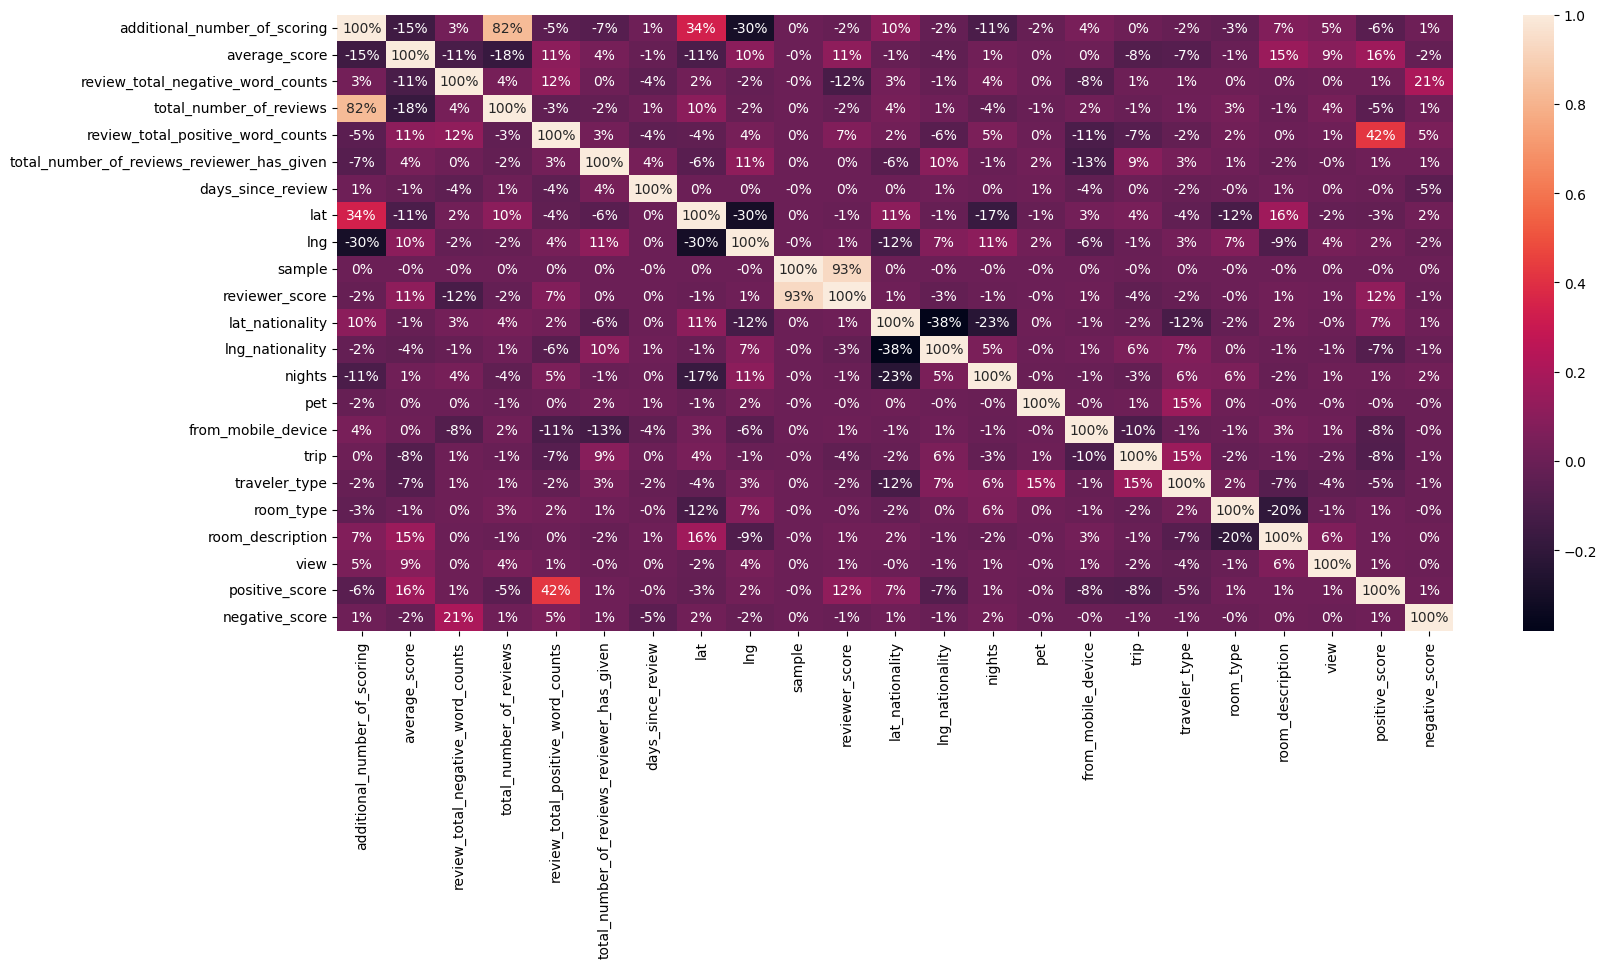

In [487]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(hotels.corr(), annot=True , fmt='.0%')

In [488]:
# непрерывные признаки
#num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts']

# категориальные признаки
#cat_cols = ['average_score', 'lat']

In [489]:
#Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат
#Разделим признаки по типу
# непрерывные признаки
num_cols = [i for i in data.columns if (data[i].dtype == 'int64' or data[i].dtype == 'float64') and i != 'reviewer_score']

# категориальные признаки
cat_cols = list(data.drop(columns=num_cols, axis=1))
num_cols, cat_cols

(['additional_number_of_scoring',
  'average_score',
  'review_total_negative_word_counts',
  'total_number_of_reviews',
  'review_total_positive_word_counts',
  'total_number_of_reviews_reviewer_has_given',
  'lat',
  'lng',
  'sample'],
 ['hotel_address',
  'review_date',
  'hotel_name',
  'reviewer_nationality',
  'negative_review',
  'positive_review',
  'tags',
  'days_since_review',
  'reviewer_score'])

In [490]:
#Разделим данные на выборки (тестовая и обучения)
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

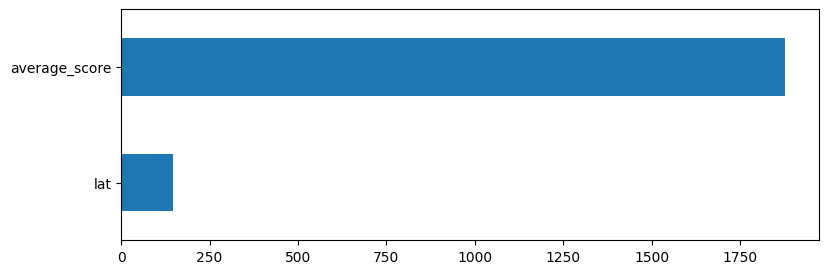

In [491]:
from sklearn.feature_selection import chi2 # хи-квадрат. Максимум 3 признака
# Показывает насколько признаки влияют на один указанный признак
y=y.astype('int') # - Целевой признак, оценка отеля "reviewer_score"

# категориальные признаки (закодированные) признаки, максимум 3
cat_cols = ['lat','average_score']

fig, ax = plt.subplots(figsize=(9,3))
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');
# По графику важности категориальных признаков мы можем понять, что признак average_score важнее, чем lat, в определении рейтинга отеля:

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


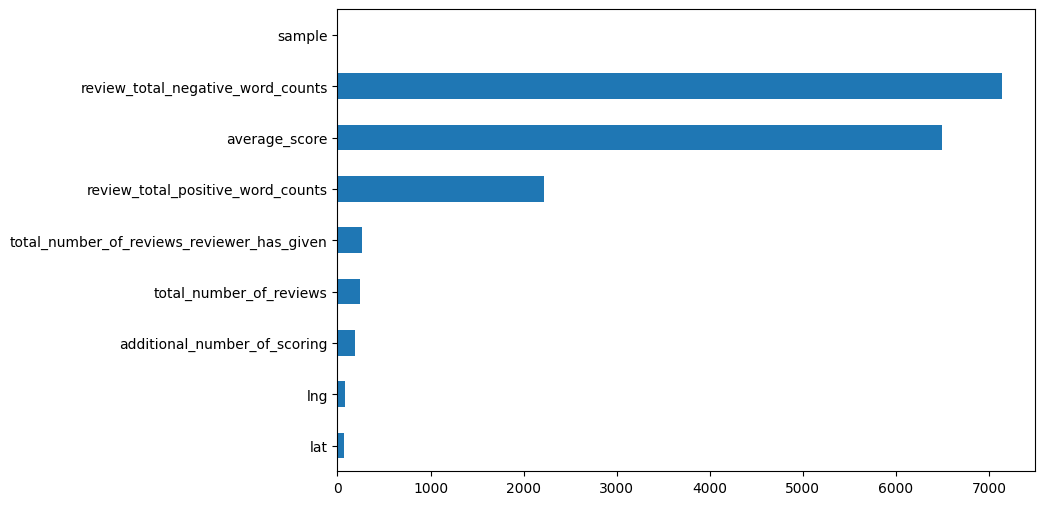

In [492]:
# Сравним несколько категориальных признаков для оценки значимости непрерывной переменной "reviewer_score"
from sklearn.feature_selection import f_classif # на основе anova, можно оценить значимость для непрерывных признаков
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(9,6))
imp_num.plot(kind = 'barh');

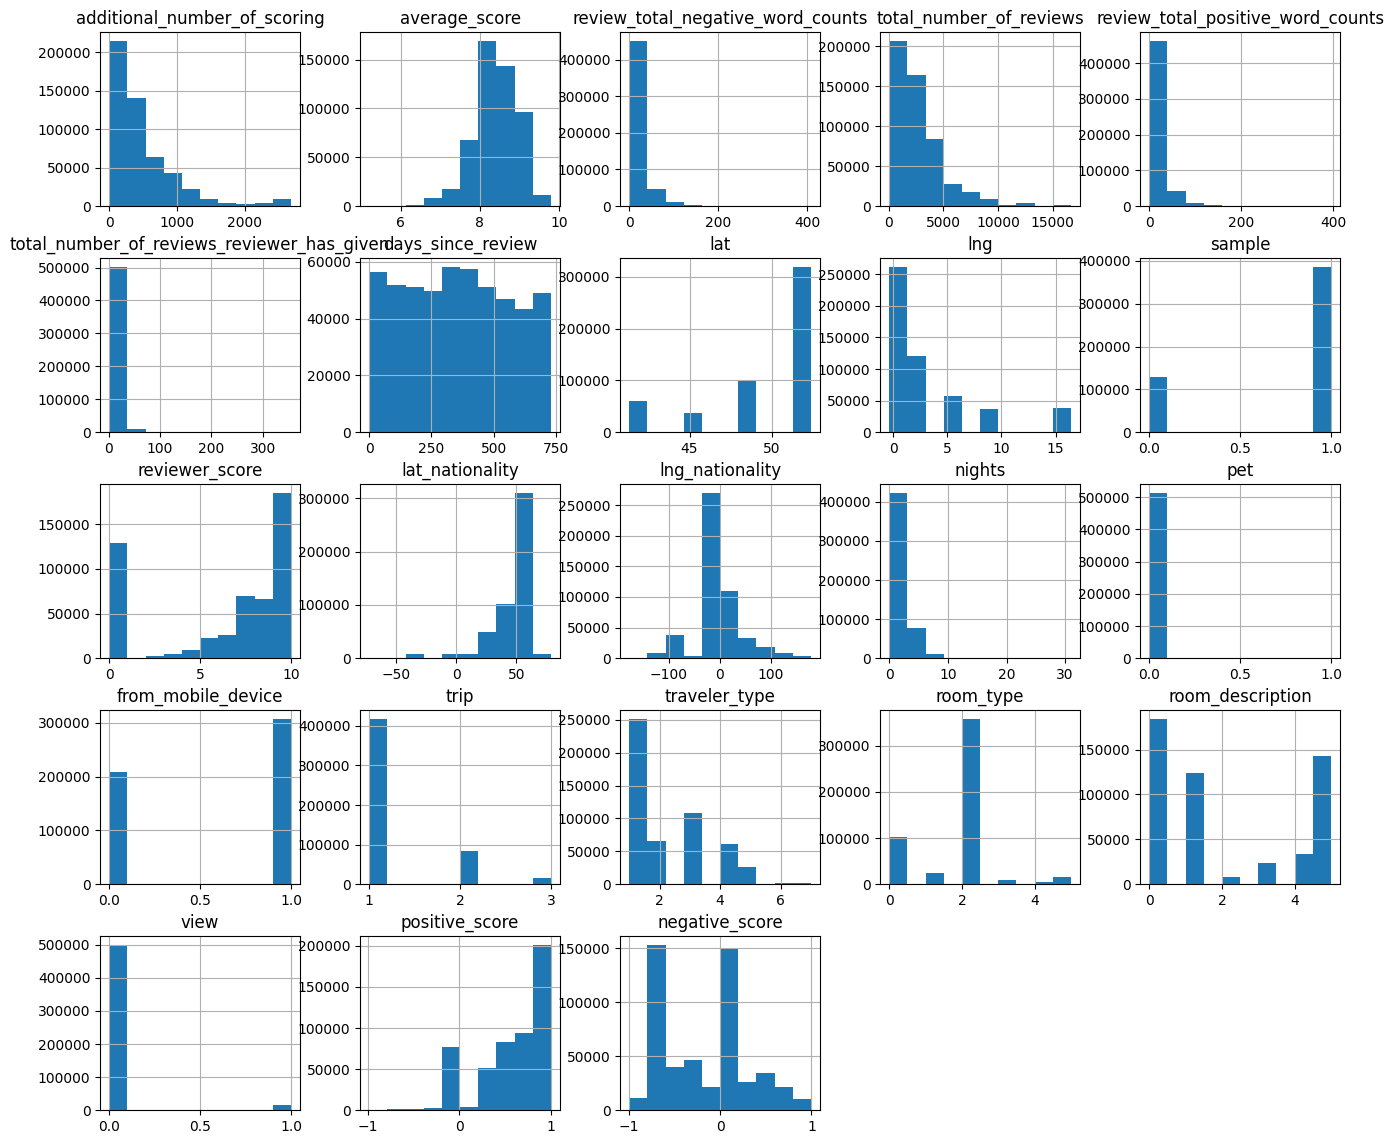

In [493]:
hotels.hist(figsize=(16,14));
#логируем гистограмму
#experiment.log_figure(figure=plt)

In [494]:
#hotels.info()

In [495]:
#Для лаьнейшей работы, предварительно уберем прропуски

#Вариант №1 заполнения медианой

median_fill = {
            'lat_nationality': hotels['lat_nationality'].median(),
            'lng_nationality': hotels['lng_nationality'].median()
            }

hotels = hotels.fillna(median_fill)
#Вариант №2 удалить строки

#n_hotels = n_hotels.dropna(how='any', axis=0)


In [496]:
hotels03 = hotels.copy()

In [497]:
#Строим модель
#Еще раз разделим данные, но уже подготовленные
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(X_train.shape, X_test.shape) 
print(y_train.shape, y_test.shape) 
# X_train относится к y_train - таблица и столбец с 75% 


(309442, 21) (77361, 21)
(309442,) (77361,)


In [498]:
###

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
print(y_pred)

###

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


[5.525 8.129 8.885 ... 7.854 7.826 8.955]


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [499]:
#test_data.info()

In [500]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE)
# - показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred)*100, '%')


MAPE: 12.54318137415089 %


In [501]:
### Попробуем улучшить модель

<Axes: >

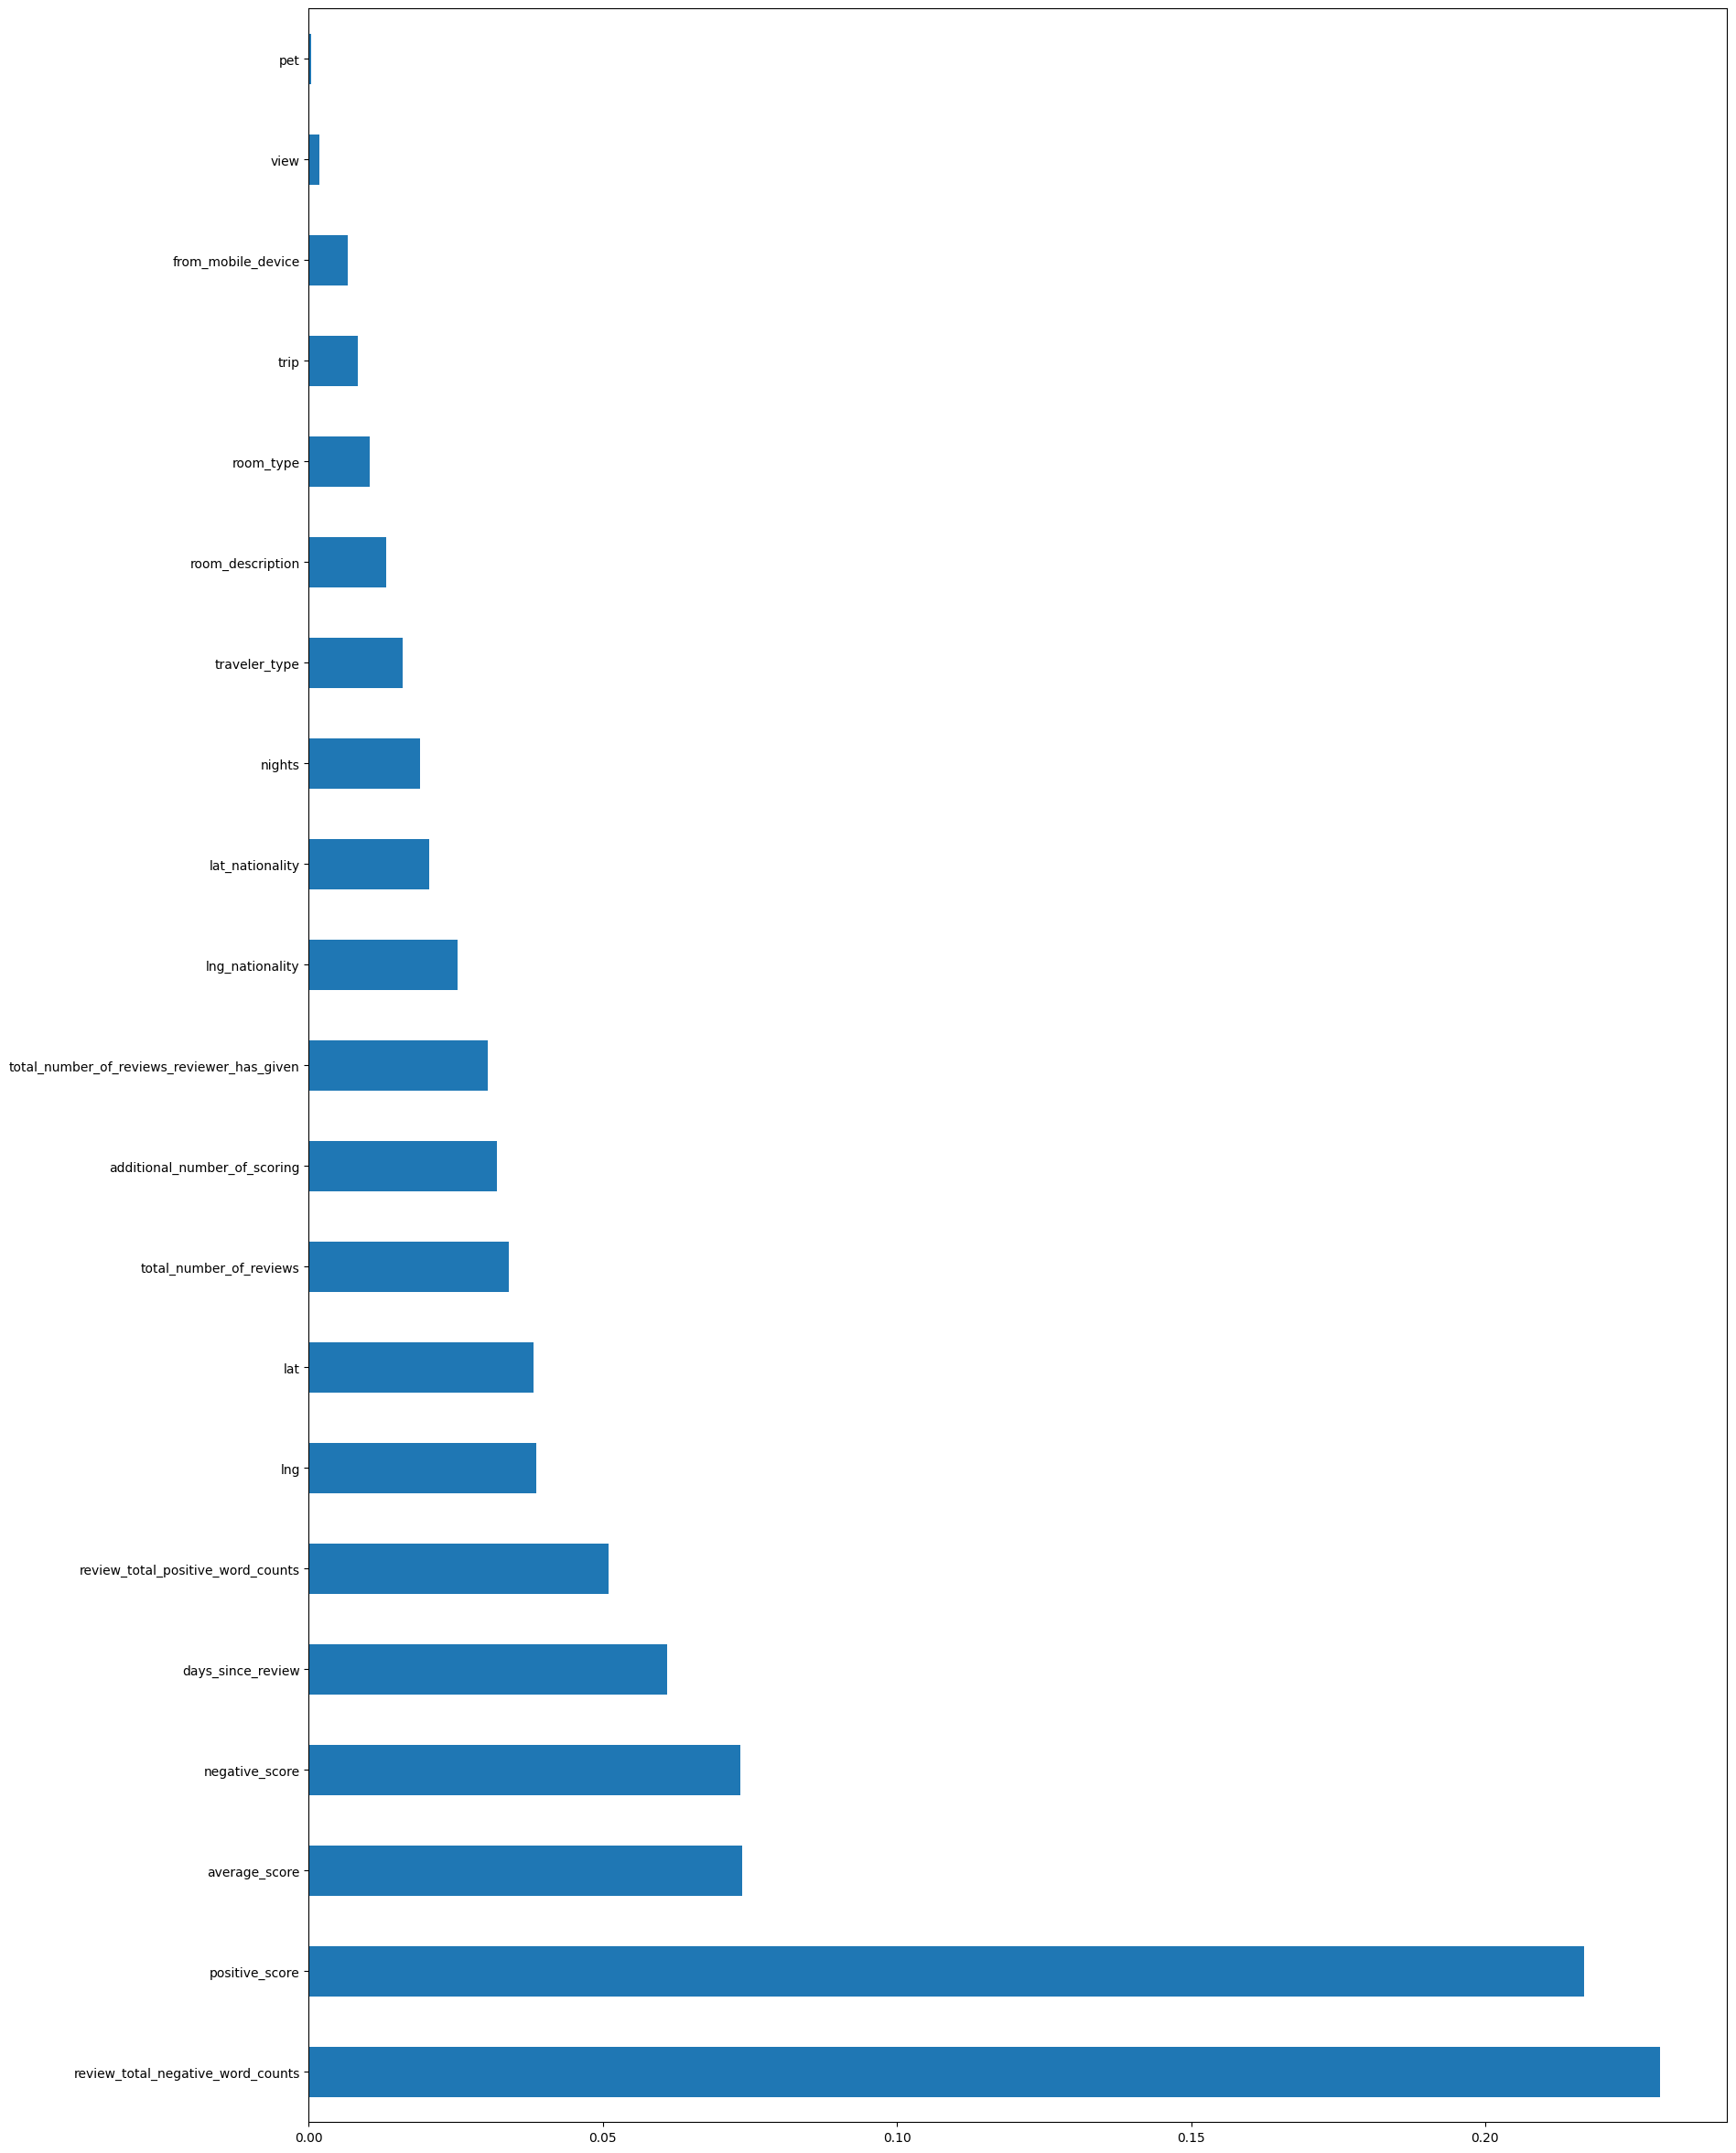

In [502]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,30)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh')

In [503]:
#Для оценки значимости категориальных переменных будем использовать изученный нами непараметрический тест хи-квадрат
#Разделим признаки по типу
# непрерывные признаки
#num = [i for i in data.columns if (data[i].dtype == 'int64' or data[i].dtype == 'float64') and i != 'reviewer_score']

# категориальные признаки
#cat = list(data.drop(columns=num, axis=1))
#num, cat

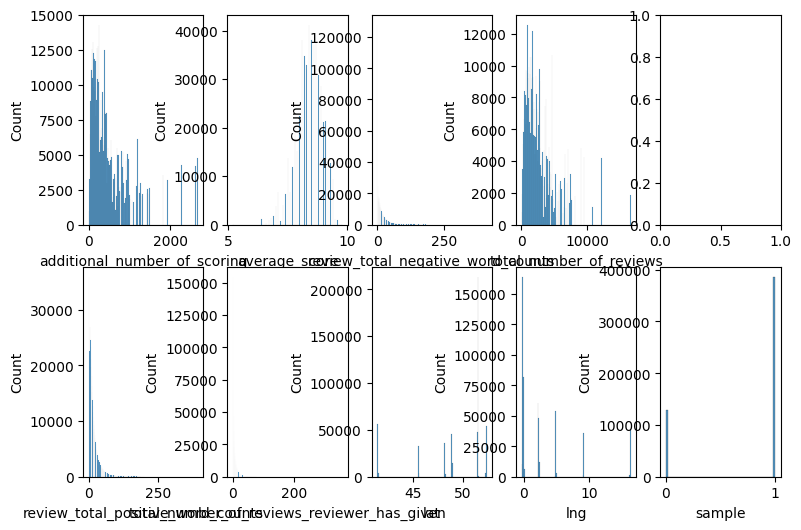

In [504]:
#Для поиска аномалий и выбросов построим графики распределения числовых признаков¶
fig, ax = plt.subplots(2,5,figsize=(9,6))

# Построим графики распределения числовых признаков
half_features = int(len(num_cols)/2) 
for index, value in enumerate(num_cols[0:half_features]):
    plot_num = sns.histplot(data= hotels[value],
                            ax= ax[0][index])
    
for index, value in enumerate(num_cols[half_features:]):
    plot_num = sns.histplot(data= hotels[value],
                            ax= ax[1][index])

In [505]:
#По графикам видно, что в признаках есть аномальные значения

#Используем метод 3х сигм (метод тьюки) для определения выбросов в числовых признаках
data_cleaner = pd.DataFrame()

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 8) # умнажая iqr на меньшее число, уменьшим диапазон усов (больше очистим)
    # ослабить границы метода Тьюки можно справа или усилить слева и наоборот. 
    upper_bound = quartile_3 + (iqr * 8) 
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    
    data_cleaner[feature] = cleaned[feature]
    return outliers, cleaned

for feature in num_cols:
        outliers, cleaned = outliers_iqr(hotels, feature)
data_cleaner.isnull().sum()

additional_number_of_scoring                     0
average_score                                    0
review_total_negative_word_counts             2305
total_number_of_reviews                          0
review_total_positive_word_counts             1432
total_number_of_reviews_reviewer_has_given    2940
lat                                              0
lng                                              0
sample                                           0
dtype: int64

In [506]:
#Для лаьнейшей работы, предварительно уберем прропуски

#Вариант №1 заполнения медианой

median_fill = {
            'total_number_of_reviews_reviewer_has_given': hotels['total_number_of_reviews_reviewer_has_given'].median(),
            'average_score': hotels['average_score'].median(),
            'review_total_negative_word_counts': hotels['review_total_negative_word_counts'].median(),
            'total_number_of_reviews': hotels['total_number_of_reviews'].median(),
            'lat': hotels['lat'].median(),
            'lng': hotels['lng'].median(),
            'review_total_positive_word_counts': hotels['review_total_positive_word_counts'].median(),
            'additional_number_of_scoring':  hotels['additional_number_of_scoring'].median()}

hotels = hotels.fillna(median_fill)
#Вариант №2 удалить строки

#hotels = hotels.dropna(how='any', axis=0)
#print(hotels[cols_cleaner].isnull().sum())

In [507]:
#Внесем полученные очищенные столбцы в датасет

cols_cleaner = list(data_cleaner.columns)
hotels[cols_cleaner] = data_cleaner[cols_cleaner]

print(hotels.isnull().sum()[num_cols])

additional_number_of_scoring                     0
average_score                                    0
review_total_negative_word_counts             2305
total_number_of_reviews                          0
review_total_positive_word_counts             1432
total_number_of_reviews_reviewer_has_given    2940
lat                                              0
lng                                              0
sample                                           0
dtype: int64


#  3. Итоговая модель

In [508]:
#Разделим данные на выборки (тестовая и обучения)¶
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
from sklearn.feature_selection import chi2 # хи-квадрат. Максимум 3 признака
# Показывает насколько признаки влияют на один указанный признак
y=y.astype('int') # - Целевой признак, оценка отеля "reviewer_score"

# категориальные признаки (закодированные) признаки, максимум 3
num_cols = ['lat','review_total_positive_word_counts','average_score']
fig = plt.figure(figsize=(10, 4))
imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

ValueError: Input contains NaN.

<Figure size 1000x400 with 0 Axes>

In [ ]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(hotels, title="Pandas Profiling Report")
#profile

In [ ]:
#import sweetviz as sv

#report = sv.analyze(hotels)
#report.show_html()

In [ ]:
#profile.to_file("your_report.html")


In [ ]:
# непрерывные признаки
#num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts']

# категориальные признаки
#cat_cols = ['average_score', 'lat']

In [ ]:
hotels.info()

In [ ]:
#hotels_clean=hotels.drop(['hotel_address','review_date','hotel_name','reviewer_nationality','negative_review','positive_review','days_since_review','tags'],axis=1)
hotels_clean=hotels.copy() #.drop(['hotel_address','review_date','hotel_name','reviewer_nationality','negative_review','positive_review','days_since_review','tags'],axis=1)
hotels_clean.fillna(value=0,inplace=True)
hotels_clean.info()

In [ ]:
hotels_clean[['positive_score', 'negative_score','reviewer_score']]

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
#X = hotels_clean.drop(['reviewer_score'], axis = 1)  
#y = hotels_clean['reviewer_score'] 

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
# Теперь выделим тестовую часть
train_data = hotels_clean.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_clean.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
data.query('sample == 0').info()

In [ ]:
X.info()

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,50)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh')

In [ ]:
test_data.drop(['reviewer_score'],axis=1,inplace=True)
test_data.info()

In [ ]:
train_data.info()

In [ ]:
predict_submission = regr.predict(test_data)
print(len(predict_submission)) 
len(sample_submission)

In [ ]:
sample_submission

In [ ]:
predict_submission = regr.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
#sample_submission = pd.read_csv( DATA_DIR + 'submission.csv' ) # самбмишн

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_pred.csv', index=False)
sample_submission

In [ ]:
## убираем признаки которые еще не успели обработать, 
## модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
#object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
#hotels.drop(object_columns, axis = 1, inplace=True)

## заполняем пропуски самым простым способом
#hotels = hotels.fillna(0)

In [ ]:
# непрерывные признаки
#num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts']

# категориальные признаки
#cat_cols = ['average_score', 'lat']

In [ ]:
#!pip install --user -U nltk

In [ ]:
#import nltk
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import time
#nltk.downloader.download('vader_lexicon')

#sent_analyzer = SentimentIntensityAnalyzer()

#rev1 = "The hotel was very good, I love it!"
#rev2 = "It was just horrible, the worst ever."

#print(f"review 1:\n{rev1}\nScore: {sent_analyzer.polarity_scores(rev1)}")

#print(f"\nreview 2:\n{rev2}\nScore: {sent_analyzer.polarity_scores(rev2)}")